<a href="https://colab.research.google.com/github/AndreaCamilloni/Online-learning-application-21-22/blob/main/OnlineMatching_CD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
from typing import List, Tuple

# Base class: Environment

In [2]:
class Environment():
    def __init__(self, n_arms, probabilities):
        self.n_arms = n_arms
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

# Matching Environment

In [3]:
class Matching_Environment(Environment):
    def __init__(self, n_arms, probabilities, horizon):
        super().__init__(n_arms, probabilities)
        self.t = 0

    def round(self, pulled_arm):
        p = self.probabilities[pulled_arm]
        self.t += 1
        reward = np.random.binomial(1, p)
        return reward

# Learner Base Class

In [4]:
class Learner:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def pull_arm(self):
        pass

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)

# UCB Base Class

In [5]:
class UCB(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.array([np.inf]*n_arms)

    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_conf == upper_conf.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = (2*np.log(self.t)/n_samples)**0.5 if n_samples > 0 else np.inf
        self.update_observations(pulled_arm, reward)

# UCB Matching Algorithm

In [6]:
class UCB_Matching(UCB):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        assert n_arms == n_rows * n_cols
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.array([np.inf]*n_arms)

    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        upper_conf[np.isinf(upper_conf)] = 1000
        # TS -> samples = # draw from beta (on e per arm)
        row_ind, col_ind = linear_sum_assignment(-upper_conf.reshape(self.n_rows, self.n_cols))
        return (row_ind, col_ind)

    def update(self, pulled_arms, rewards):
        # TS -> update beta and alphas of the beta distribuitions
        self.t += 1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))
        for pulled_arm, reward in zip(pulled_arms_flat, rewards):
            self.update_observations(pulled_arm, reward)
            self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = (2*np.log(self.t)/n_samples)**0.5 if n_samples > 0 else np.inf

# Testing UCB Matching

In [7]:
p0 = np.array([[1/4, 1, 1/4], [1/2, 1/4, 1/4], [1/4, 1/4, 1]])
T = 3000
n_exp = 10
regret_ucb = np.zeros((n_exp, T))
for j in range(n_exp):
    env = Matching_Environment(p0.size, p0, T)
    learner_UCB = UCB_Matching(p0.size, *p0.shape)
    opt_rew = []
    rew_UCB = []
    for t in range(T):
        p = p0    
        opt = linear_sum_assignment(-p)
        opt_rew.append(p[opt].sum())
        pulled_arm = learner_UCB.pull_arm()
        reward = env.round(pulled_arm)
        learner_UCB.update(pulled_arm, reward)
        rew_UCB.append(reward.sum())

    regret_ucb[j, :] = np.cumsum(opt_rew)-np.cumsum(rew_UCB)

# Plot

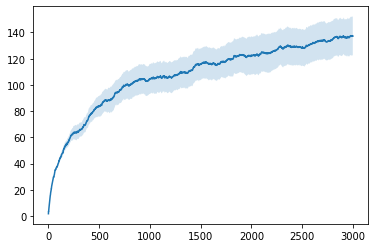

In [8]:
mean = np.mean(regret_ucb, axis=0)
std = np.std(regret_ucb, axis=0)/np.sqrt(n_exp)
plt.figure(0)
plt.plot(mean)
plt.fill_between(range(len(mean)), mean-std, mean+std, alpha = 0.2)
plt.show()

# Non Stationary Matching Environment

In [9]:
class Non_Stationary_Environment(Environment):
    def __init__(self, n_arms, probabilities, horizon):
        super().__init__(n_arms, probabilities)
        self.t = 0
        n_phases = len(self.probabilities)
        self.phase_size = horizon/n_phases

    def round(self, pulled_arm):
        current_phase = int(self.t / self.phase_size)
        p = self.probabilities[current_phase][pulled_arm]
        self.t += 1
        reward = np.random.binomial(1, p)
        return reward

# CUSUM Algorithm

In [10]:
class CUSUM:
    def __init__(self, M, eps, h):
        """
        intialize the relevant variables
        """

    def update(self, sample: float) -> bool:
        """
        takes a 1d sample and return True if a detection was flagged
        """

    def reset(self):
        """
        reset all the relevant variables
        """

In [11]:
class CUSUM:
    def __init__(self, M, eps, h):
        self.M = M
        self.eps = eps
        self.h = h
        self.t = 0
        self.reference = 0
        self.g_plus = 0
        self.g_minus = 0

    def update(self, sample):
        self.t += 1
        if self.t <= self.M:
            self.reference += sample/self.M
            return False
        else:
            self.reference = (self.reference*(t-1) + sample)/t
            s_plus = (sample - self.reference) - self.eps
            s_minus = -(sample - self.reference) - self.eps
            self.g_plus = max(0, self.g_plus + s_plus)
            self.g_minus = max(0, self.g_minus + s_minus)
            return self.g_plus > self.h or self.g_minus > self.h

    def reset(self):
        self.g_minus = 0
        self.g_plus = 0
        self.t = 0
        self.reference = 0

# TEST CUSUM

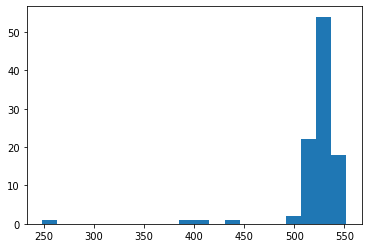

In [12]:
p0 = 0.6
p1 = 0.2

eps = 0.03
M = 200
T = 1000
h = np.log(T)*2
CD = CUSUM(M, eps, h)
S = []
n_exp = 100
for _ in range(n_exp):
    CD.reset()
    for t in range(T):
        p = p0 if t < 500 else p1
        sample = np.random.binomial(1, p)
        if CD.update(sample):
            S.append(t)
            break

plt.figure(0)
plt.hist(S, bins=20)
plt.show()

In [13]:
S

[552,
 414,
 519,
 531,
 533,
 535,
 530,
 532,
 536,
 521,
 534,
 533,
 521,
 522,
 522,
 535,
 526,
 518,
 517,
 535,
 541,
 510,
 525,
 542,
 552,
 524,
 535,
 523,
 525,
 541,
 528,
 532,
 525,
 523,
 536,
 445,
 542,
 528,
 532,
 526,
 520,
 543,
 544,
 532,
 524,
 534,
 519,
 524,
 518,
 523,
 531,
 535,
 525,
 520,
 533,
 512,
 537,
 514,
 527,
 524,
 531,
 537,
 525,
 532,
 529,
 511,
 511,
 526,
 529,
 520,
 522,
 531,
 506,
 526,
 513,
 530,
 547,
 511,
 534,
 526,
 541,
 506,
 541,
 514,
 395,
 521,
 526,
 524,
 517,
 551,
 540,
 542,
 512,
 546,
 525,
 532,
 248,
 530,
 540,
 520]

# CUSUM UCB

In [14]:
class CUSUM_UCB_Matching(UCB_Matching):
    def __init__(self, n_arms, n_rows, n_cols, M=100, eps=0.05, h=20, alpha=0.01):
        super().__init__(n_arms, n_rows, n_cols)
        self.change_detection = [CUSUM(M, eps, h) for _ in range(n_arms)]
        self.valid_rewards_per_arm = [[] for _ in range(n_arms)]
        self.alpha = alpha
        self.detections = []

    def pull_arm(self):
        if np.random.binomial(1, 1-self.alpha):
            upper_conf = self.empirical_means + self.confidence
            upper_conf[np.isinf(upper_conf)] = 1000
            row_ind, col_ind = linear_sum_assignment(-upper_conf.reshape(self.n_rows, self.n_cols))
            return (row_ind, col_ind)
        else:
            costs_random = np.random.randint(0, 10, size=(self.n_rows, self.n_cols))
            return linear_sum_assignment(costs_random)

    def update(self, pulled_arms, rewards):
        self.t += 1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))
        for pulled_arm, reward in zip(pulled_arms_flat, rewards):
            if self.change_detection[pulled_arm].update(reward):
                self.detections.append(self.t)
                self.valid_rewards_per_arm[pulled_arm] = []
                self.change_detection[pulled_arm].reset()
            self.update_observations(pulled_arm, reward)
            self.empirical_means[pulled_arm] = np.mean(self.valid_rewards_per_arm[pulled_arm])
        total_valid_samples = sum([len(x) for x in self.valid_rewards_per_arm])
        for a in range(self.n_arms):
            valid_samples = len(self.valid_rewards_per_arm[a])
            self.confidence[a] = (2*np.log(total_valid_samples)/valid_samples)**0.5 if valid_samples > 0 else np.inf

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.valid_rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)

# Testing CUSUMUCB

In [ ]:
p0 = np.array([[1/4, 1, 1/4], [1/2, 1/4, 1/4], [1/4, 1/4, 1]])
p1 = np.array([[1, 1/4, 1/4], [1/2, 1/4, 1/4], [1/4, 1/4, 1]])
p2 = np.array([[1, 1/4, 1/4], [1/2, 1, 1/4], [1/4, 1/4, 1]])
P = [p0, p1, p2]
T = 3000
n_exp = 5
regret_cusum = np.zeros((n_exp, T))
regret_ucb = np.zeros((n_exp, T))
detections = [[] for _ in range(n_exp)]
M = 100
eps = 0.1
h = np.log(T)*2
for j in range(n_exp):
    e_UCB = Non_Stationary_Environment(p0.size, P, T)
    e_CD = Non_Stationary_Environment(p0.size, P, T)
    learner_CD = CUSUM_UCB_Matching(p0.size, *p0.shape, M, eps, h)
    learner_UCB = UCB_Matching(p0.size, *p0.shape)
    opt_rew = []
    rew_CD = []
    rew_UCB = []
    for t in range(T):
        p = P[int(t / e_UCB.phase_size)]
        opt = linear_sum_assignment(-p)
        opt_rew.append(p[opt].sum())

        pulled_arm = learner_CD.pull_arm()
        reward = e_CD.round(pulled_arm)
        learner_CD.update(pulled_arm, reward)
        rew_CD.append(reward.sum())

        pulled_arm = learner_UCB.pull_arm()
        reward = e_UCB.round(pulled_arm)
        learner_UCB.update(pulled_arm, reward)
        rew_UCB.append(reward.sum())

    regret_cusum[j, :] = np.cumsum(opt_rew)-np.cumsum(rew_CD)
    regret_ucb[j, :] = np.cumsum(opt_rew)-np.cumsum(rew_UCB)
mean_regret_cusum = np.mean(regret_cusum, axis=0)
mean_regret_ucb = np.mean(regret_ucb, axis=0)
std_cusum = np.std(regret_cusum, axis=0)/np.sqrt(n_exp)
std_ucb = np.std(regret_ucb, axis=0)/np.sqrt(n_exp)

In [ ]:
plt.figure(0)
plt.plot(mean_regret_cusum)
plt.fill_between(range(len(mean_regret_cusum)), mean_regret_cusum-std_cusum, mean_regret_cusum+std_cusum, alpha = 0.2)
plt.plot(mean_regret_ucb)
plt.fill_between(range(len(mean_regret_ucb)), mean_regret_ucb-std_ucb, mean_regret_ucb+std_ucb, alpha = 0.2)
plt.legend(['cusum', 'ucb'])
plt.show()

In [ ]:
pulled_arm